In [1]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib
import lifelines


In [2]:
df = pd.read_csv('helpdesk.csv')
df["start_date"] = pd.to_datetime(df["start_date"], format="%Y-%m-%d")
df["end_date"]   = pd.to_datetime(df["end_date"],   format="%Y-%m-%d", errors="coerce")

In [3]:
df['experience_cat']


0       medium
1       medium
2          low
3          low
4       medium
         ...  
8110    medium
8111    medium
8112       low
8113      high
8114    medium
Name: experience_cat, Length: 8115, dtype: object

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      8115 non-null   datetime64[ns]
 1   priority        8115 non-null   object        
 2   experience_cat  8115 non-null   object        
 3   team_size       8115 non-null   int64         
 4   budget          8115 non-null   int64         
 5   type            8115 non-null   object        
 6   status          8115 non-null   object        
 7   end_date        6846 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 507.3+ KB


In [5]:
df_ibs = pd.DataFrame()

df_ibs = pd.get_dummies(df, columns=['priority', 'experience_cat', 'type'], drop_first=False)
df_ibs["Event"] = df["status"].map({'completed': 1, 'ongoing': 0, 'cancelled': 0})
df_ibs['Censoring'] = df['status'] == 'cancelled'
df_ibs['team_size'] = df['team_size']
df_ibs['budget'] = df['budget']

df_ibs["stop_date"] = df_ibs["end_date"]
cutoff = df_ibs["start_date"].max()  # of een vaste datum, of df_ibs["start_date"].max()

df_ibs.loc[df_ibs["stop_date"].isna(), "stop_date"] = cutoff
df_ibs["Survival_time"] = (df_ibs["stop_date"] - df_ibs["start_date"]).dt.days
df_ibs["HH"] = (df_ibs['experience_cat_high'] & df_ibs['priority_high'])
df_ibs["MH"] = (df_ibs['experience_cat_medium'] & df_ibs['priority_medium'])

df_ibs['experience_cat'] = df['experience_cat']
df_ibs['priority'] = df['priority']
df_ibs['type'] = df['type']



df_ibs[2000:2015]

,start_date,team_size,budget,status,end_date,priority_high,priority_low,priority_medium,experience_cat_high,experience_cat_low,...,type_feature,Event,Censoring,stop_date,Survival_time,HH,MH,experience_cat,priority,type
2000,2025-06-07,10,51400,completed,2025-06-15,False,True,False,False,False,...,False,1,False,2025-06-15,8,False,False,medium,low,bug
2001,2025-06-07,7,62700,completed,2025-07-21,False,True,False,False,True,...,False,1,False,2025-07-21,44,False,False,low,low,bug
2002,2025-06-07,4,47900,completed,2025-06-30,False,False,True,False,True,...,True,1,False,2025-06-30,23,False,False,low,medium,feature
2003,2025-06-07,6,41600,completed,2025-06-20,False,False,True,False,True,...,False,1,False,2025-06-20,13,False,False,low,medium,bug
2004,2025-06-07,7,45900,completed,2025-06-29,False,False,True,False,True,...,True,1,False,2025-06-29,22,False,False,low,medium,feature
2005,2025-06-07,4,35900,completed,2025-06-24,True,False,False,False,False,...,False,1,False,2025-06-24,17,False,False,medium,high,bug
2006,2025-06-07,4,48300,completed,2025-06-29,False,False,True,False,True,...,False,1,False,2025-06-29,22,False,False,low,medium,bug
2007,2025-06-07,7,50300,completed,2025-07-03,True,False,False,False,False,...,True,1,False,2025-07-03,26,False,False,medium,high,feature
2008,2025-06-07,6,41600,completed,2025-07-02,True,False,False,False,True,...,False,1,False,2025-07-02,25,False,False,low,high,bug
2009,2025-06-07,5,79900,completed,2025-07-03,False,False,True,False,True,...,False,1,False,2025-07-03,26,False,False,low,medium,bug


In [6]:
df_ibs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8115 entries, 0 to 8114
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   start_date             8115 non-null   datetime64[ns]
 1   team_size              8115 non-null   int64         
 2   budget                 8115 non-null   int64         
 3   status                 8115 non-null   object        
 4   end_date               6846 non-null   datetime64[ns]
 5   priority_high          8115 non-null   bool          
 6   priority_low           8115 non-null   bool          
 7   priority_medium        8115 non-null   bool          
 8   experience_cat_high    8115 non-null   bool          
 9   experience_cat_low     8115 non-null   bool          
 10  experience_cat_medium  8115 non-null   bool          
 11  type_bug               8115 non-null   bool          
 12  type_chore             8115 non-null   bool          
 13  typ

In [7]:
cph = lifelines.CoxPHFitter()
cph.fit(df_ibs, "Survival_time", "Event",
        formula="team_size + budget + priority_high * experience_cat_medium + priority_high * experience_cat_high + type_bug + type_chore + type_doc")


<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [8]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53957.83
         time fit was run = 2026-01-22 08:39:34 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
team_size                           -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
budget                              -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
priority_high                        0.01      1.01      0.05           -0.09            0.11                0.91                1.12
experience_cat_medium                0.07      1.08      0.03            0.01            0.14                1.01                1.15
experience_cat_high                  0.04      1.04      0.04           -0.04            0.12                0.96                1.13
type_bug                             0.03      1.03      0.03           -0.02            0.08                0.98                1.09
type_chore                           0.08      1.08      0.04            0.00            0.15                1.00                1.16
type_doc                            -0.04      0.96      0.06           -0.15            0.08                0.86                1.08
priority_high:experience_cat_medium  0.01      1.01      0.07           -0.12            0.13                0.89                1.14
priority_high:experience_cat_high    0.17      1.18      0.08            0.01            0.33                1.01                1.39

                                     cmp to     z    p  -log2(p)
covariate                                                       
team_size                              0.00 -0.20 0.84      0.25
budget                                 0.00 -0.32 0.75      0.41
priority_high                          0.00  0.18 0.85      0.23
experience_cat_medium                  0.00  2.23 0.03      5.29
experience_cat_high                    0.00  0.89 0.37      1.42
type_bug                               0.00  1.12 0.26      1.92
type_chore                             0.00  2.06 0.04      4.68
type_doc                               0.00 -0.62 0.53      0.91
priority_high:experience_cat_medium    0.00  0.10 0.92      0.12
priority_high:experience_cat_high      0.00  2.09 0.04      4.79
---
Concordance = 0.51
Partial AIC = 107935.67
log-likelihood ratio test = 22.41 on 10 df
-log2(p) of ll-ratio test = 6.25

<Axes: xlabel='log(HR) (95% CI)'>

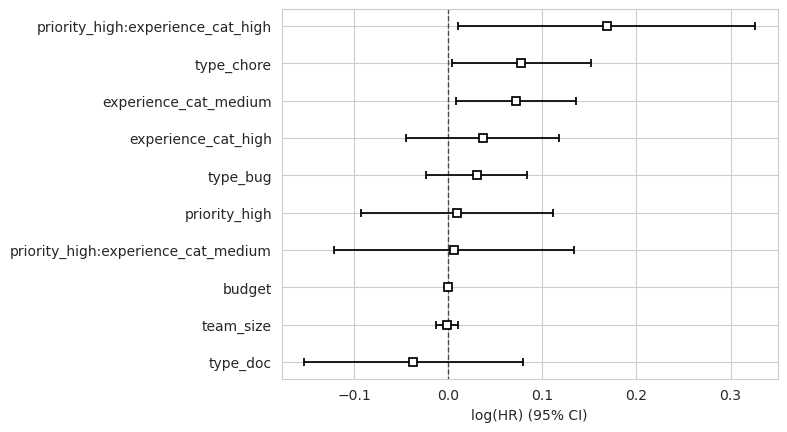

In [9]:
cph.plot()

In [10]:
cph2 = lifelines.CoxPHFitter()
cph2.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "HH + type_chore")

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [11]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53962.72
         time fit was run = 2026-01-22 08:39:35 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
HH          0.17      1.18      0.05            0.06            0.27                1.06                1.31
type_chore  0.06      1.07      0.03           -0.00            0.13                1.00                1.14

            cmp to    z      p  -log2(p)
covariate                               
HH            0.00 3.08 <0.005      8.91
type_chore    0.00 1.86   0.06      4.00
---
Concordance = 0.50
Partial AIC = 107929.44
log-likelihood ratio test = 12.64 on 2 df
-log2(p) of ll-ratio test = 9.12

<Axes: xlabel='log(HR) (95% CI)'>

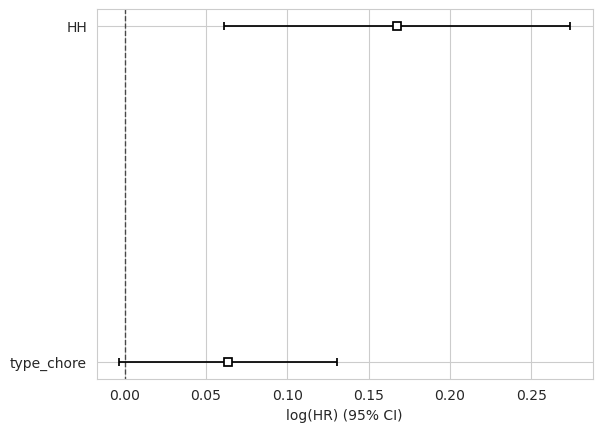

In [12]:
cph2.plot()

In [13]:
cph3 = lifelines.CoxPHFitter()
cph3.fit(df_ibs, duration_col='Survival_time', event_col='Event', formula = "HH")

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>

In [14]:
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 8115 total observations, 1315 right-censored observations>
             duration col = 'Survival_time'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 8115
number of events observed = 6800
   partial log-likelihood = -53964.43
         time fit was run = 2026-01-22 08:39:35 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
HH         0.17      1.18      0.05            0.06            0.28                1.06                1.32

           cmp to    z      p  -log2(p)
covariate                              
HH           0.00 3.11 <0.005      9.07
---
Concordance = 0.50
Partial AIC = 107930.85
log-likelihood ratio test = 9.22 on 1 df
-log2(p) of ll-ratio test = 8.71

<Axes: xlabel='log(HR) (95% CI)'>

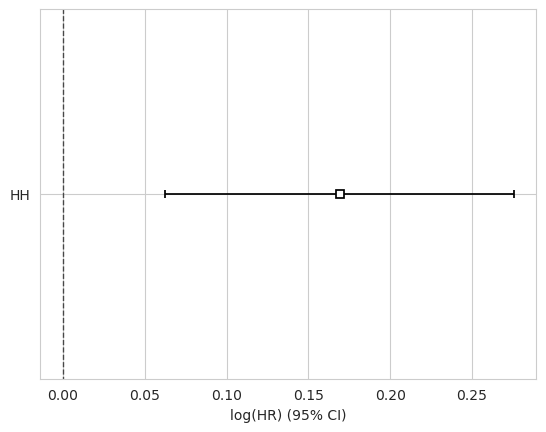

In [15]:
cph3.plot()

In [16]:
kmf = lifelines.KaplanMeierFitter()

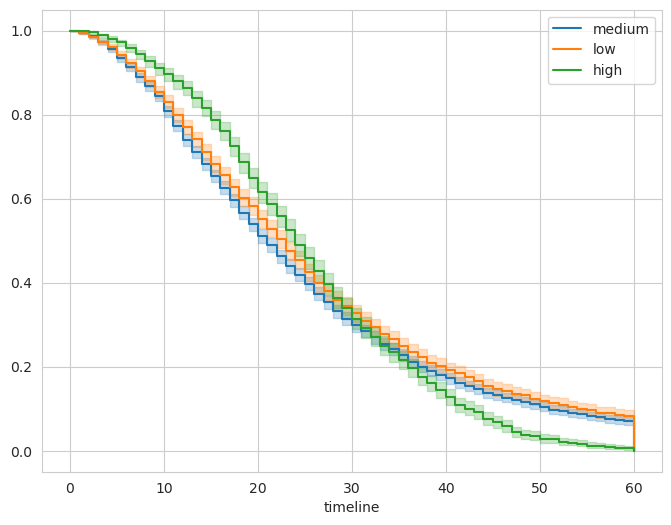

In [17]:
plt.figure(figsize=(8,6))

for level in df_ibs['experience_cat'].unique():
    mask = df_ibs['experience_cat'] == level
    kmf.fit(
        durations=df_ibs.loc[mask, 'Survival_time'],
        event_observed=df_ibs.loc[mask, 'Event'],
        label=level
    )
    
    kmf.plot_survival_function()
plt.show()

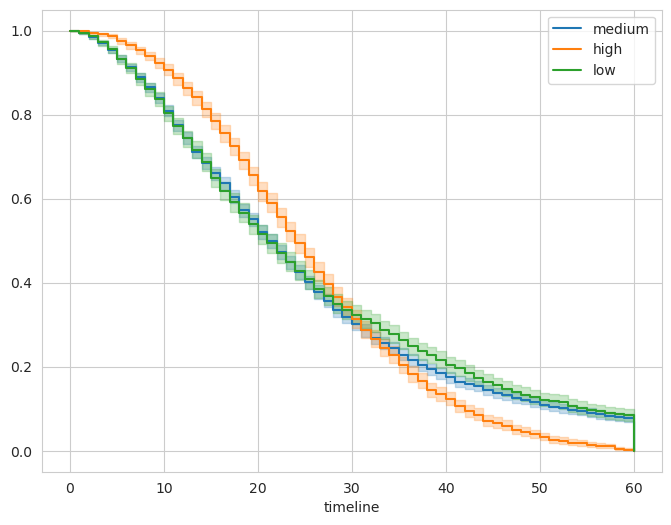

In [18]:
plt.figure(figsize=(8,6))

for level in df_ibs['priority'].unique():
    mask = df_ibs['priority'] == level
    kmf.fit(
        durations=df_ibs.loc[mask, 'Survival_time'],
        event_observed=df_ibs.loc[mask, 'Event'],
        label=level
    )
    
    kmf.plot_survival_function()
plt.show()

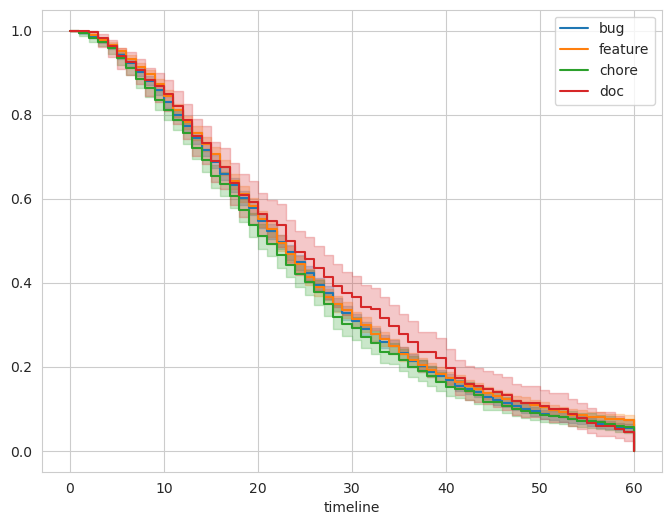

In [19]:
plt.figure(figsize=(8,6))

for level in df_ibs['type'].unique():
    mask = df_ibs['type'] == level
    kmf.fit(
        durations=df_ibs.loc[mask, 'Survival_time'],
        event_observed=df_ibs.loc[mask, 'Event'],
        label=level
    )
    
    kmf.plot_survival_function()
plt.show()

In [46]:
tau = 60


In [47]:

def rmst(durations, events, tau):
    kmf = KaplanMeierFitter()
    kmf.fit(durations, event_observed=events)
    
    survival = kmf.survival_function_
    survival = survival.loc[survival.index <= tau]
    
    # voeg tau toe als laatste punt
    if survival.index[-1] < tau:
        last_surv = survival.iloc[-1, 0]
        survival.loc[tau] = last_surv
    
    # sorteer op tijd
    survival = survival.sort_index()
    
    # numerieke integratie (trapeziumregel)
    times = survival.index.values
    surv_probs = survival.iloc[:, 0].values
    
    return np.trapz(surv_probs, times)


In [48]:

rmst_results = {}

for level in df['experience_cat'].unique():
    mask = df_ibs['experience_cat'] == level
    rmst_results[level] = rmst(
        df_ibs.loc[mask, 'Survival_time'],
        df_ibs.loc[mask, 'Event'],
        tau
    )

rmst_results


{'medium': 24.248976214976068,
 'low': 25.47649436105893,
 'high': 25.00934286350612}

In [49]:
for level in df['priority'].unique():
    mask = df_ibs['priority'] == level
    print(level, rmst(
        df_ibs.loc[mask, 'Survival_time'],
        df_ibs.loc[mask, 'Event'],
        tau
    ))


medium 24.49554476826408
high 25.009056460790582
low 25.07794107738319


In [50]:
for level in df['type'].unique():
    mask = df_ibs['type'] == level
    print(level, rmst(
        df_ibs.loc[mask, 'Survival_time'],
        df_ibs.loc[mask, 'Event'],
        tau
    ))


bug 24.68477959019639
feature 25.128757939604892
chore 23.838729958144004
doc 25.880673155275677


In [53]:
for exp in df['experience_cat'].unique():
    for pr in df_ibs['priority'].unique():
        mask = (df_ibs['experience_cat'] == exp) & (df_ibs['priority'] == pr)
        if mask.sum() > 50:  # voorkom kleine groepen
            value = rmst(
                df_ibs.loc[mask, 'Survival_time'],
                df_ibs.loc[mask, 'Event'],
                tau
            )
            print(exp, pr, round(value, 2))


medium medium 24.0
medium high 25.05
medium low 23.9
low medium 24.69
low high 26.3
low low 26.24
high medium 25.39
high high 23.03
high low 26.3


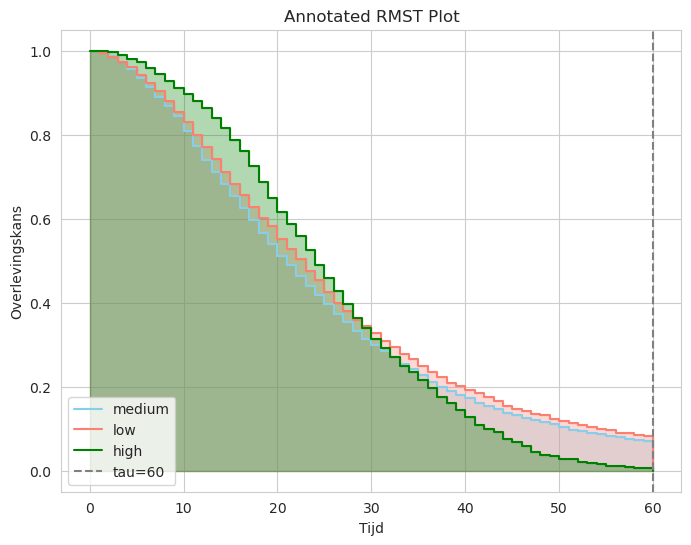

In [55]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

groups = df_ibs['experience_cat'].unique()
colors = ['skyblue', 'salmon', 'green']

plt.figure(figsize=(8,6))

for i, group in enumerate(groups):
    mask = df_ibs['experience_cat'] == group
    kmf = KaplanMeierFitter()
    kmf.fit(df_ibs.loc[mask, 'Survival_time'], event_observed=df_ibs.loc[mask, 'Event'])
    
    # Plot de curve
    kmf.plot_survival_function(ci_show=False, color=colors[i], label=f"{group}")
    
    # Alleen waarden t <= tau
    times = kmf.survival_function_.index.values
    surv_probs = kmf.survival_function_['KM_estimate'].values
    times = times[times <= tau]
    surv_probs = surv_probs[:len(times)]
    
    # Vul onder de curve tot tau
    plt.fill_between(times, surv_probs, step="post", color=colors[i], alpha=0.3)

# Optionele verticale lijn bij tau
plt.axvline(x=tau, color='gray', linestyle='--', label=f'tau={tau}')
plt.xlabel('Tijd')
plt.ylabel('Overlevingskans')
plt.title('Annotated RMST Plot')
plt.legend()
plt.show()


In [56]:
def rmst_interval(durations, events, start, end):
    """
    Bereken RMST tussen start en end (bijv. dagen 30-60).
    """
    kmf = KaplanMeierFitter()
    kmf.fit(durations, event_observed=events)
    
    survival = kmf.survival_function_
    
    # Alleen waarden tussen start en end
    survival = survival.loc[(survival.index >= start) & (survival.index <= end)]
    
    # Voeg start en end toe als die niet exact in de index zitten
    if start not in survival.index:
        surv_at_start = kmf.predict(start)
        survival.loc[start] = surv_at_start
    if end not in survival.index:
        surv_at_end = kmf.predict(end)
        survival.loc[end] = surv_at_end
    
    # Sorteer op tijd
    survival = survival.sort_index()
    
    # Integreer numeriek
    times = survival.index.values
    surv_probs = survival.iloc[:, 0].values
    return np.trapz(surv_probs, times)


In [57]:
rmst_30_60 = {}

for level in df_ibs['experience_cat'].unique():
    mask = df['experience_cat'] == level
    rmst_30_60[level] = rmst_interval(
        df_ibs.loc[mask, 'Survival_time'],
        df_ibs.loc[mask, 'Event'],
        start=30,
        end=60
    )

rmst_30_60


{'medium': 4.44227215244521,
 'low': 4.966345283264253,
 'high': 3.0009943203716176}